<a href="https://colab.research.google.com/github/seungjae6874/Deeplearning/blob/master/siamese_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 코드로 형식 지정됨
Imports
모든 import 해야 할 것들을 정의해 줍니다.

In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

Helper functions
필요한 함수들을 설정해줍니다.

In [0]:
def imshow(img,text = None, should_save = False):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text, style='italic',fontweight='bold',
             bbox={'facecolor':'white','alpha':0.8,'pad':10})
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Configuration Class
간단한 클래스들을 통해 data사진이 있는 경로를 선언해주고 에폭과 배치사이즈를 설정해줍니다.

In [0]:
class Config():
  training_dir = "/content/drive/My Drive/siamese/data/faces/training/"
  testing_dir = "/content/drive/My Drive/siamese/data/faces/testing/"
  train_batch_size = 64
  train_number_epochs = 100

Custom Dataset Class
데이터셋은 한 쌍의 이미지들로써 생성됩니다.
0의 값은 정답의 이미지를 갖는 쌍
1의 값은 거짓의 사진 즉, 일치하지 않는 사진인 쌍을 의미합니다.

In [0]:

class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Using Image Folder Dataset

In [0]:
folder_dataset= dset.ImageFolder(root = Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                       transforms.ToTensor()]),should_invert=False)

Visualising some of the data
이제 데이터를 로드한 후에 훈련시에는 shuffle을 하고 한번 돌려보자
한쌍의 사진에 대해 1이면 두 사진은 맞지 않고 0이면 같은 인물임을 판단해낸다.

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


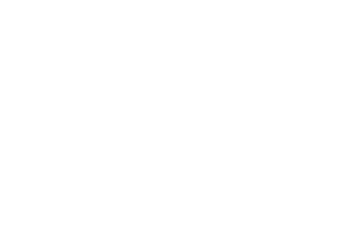

In [161]:
vis_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=8,batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

Neural Net Definition
표준의 cnn을 사용할 것이다.

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

Contrastive Loss
Loss를 구해서 gradient를 업데이트 시키자

In [0]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1,output2,label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

Training Time!

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.9816834926605225

Epoch number 1
 Current loss 5.873642921447754

Epoch number 2
 Current loss 1.9641510248184204

Epoch number 3
 Current loss 0.5400514602661133

Epoch number 4
 Current loss 0.7097876071929932

Epoch number 5
 Current loss 0.5240793228149414

Epoch number 6
 Current loss 0.635358452796936

Epoch number 7
 Current loss 0.4231724143028259

Epoch number 8
 Current loss 0.2986968755722046

Epoch number 9
 Current loss 0.25322389602661133

Epoch number 10
 Current loss 0.19964434206485748

Epoch number 11
 Current loss 0.1437923163175583

Epoch number 12
 Current loss 0.14833873510360718

Epoch number 13
 Current loss 0.20668736100196838

Epoch number 14
 Current loss 0.1008983626961708

Epoch number 15
 Current loss 0.13158763945102692

Epoch number 16
 Current loss 0.18940606713294983

Epoch number 17
 Current loss 0.16330879926681519

Epoch number 18
 Current loss 0.1409822255373001

Epoch number 19
 Current loss 0.12300226837396622

Epoc

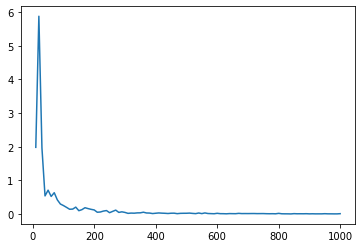

In [167]:
for epoch in range(0,Config.train_number_epochs):
  for i,data in enumerate(train_dataloader,0):
    img0,img1,label = data
    img0,img1,label = img0.cuda(),img1.cuda(),label.cuda()
    optimizer.zero_grad()
    output1, output2 = net(img0,img1)
    loss_contrastive = criterion(output1, output2, label)
    loss_contrastive.backward()
    optimizer.step()
    if i%10 == 0:
      print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
      iteration_number += 10
      counter.append(iteration_number)
      loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

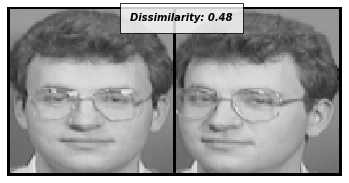

Both are maybe same Person


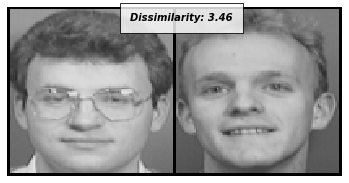

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


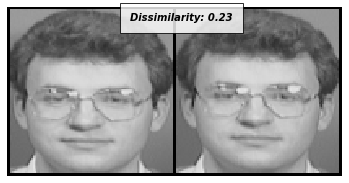

Both are maybe same Person


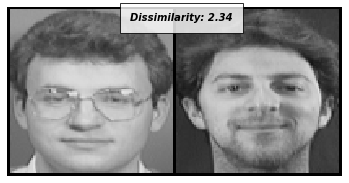

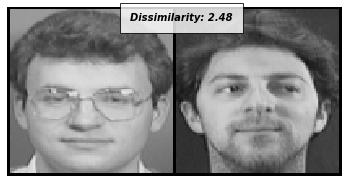

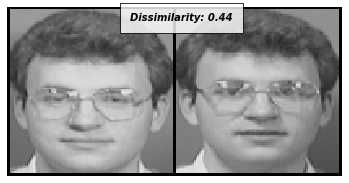

Both are maybe same Person


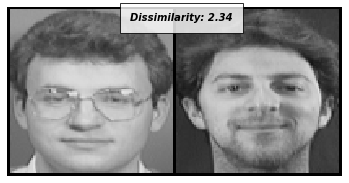

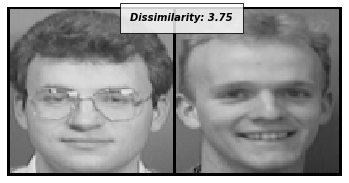

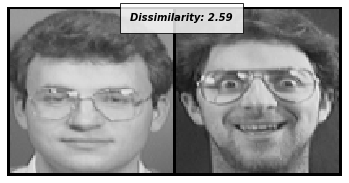

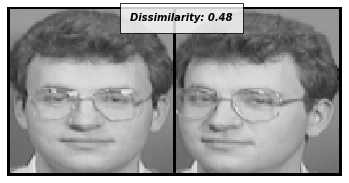

Both are maybe same Person


In [170]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    if (euclidean_distance.item() < 1):
      print("Both are maybe same Person")